In [ ]:
#Import das bibliotecas e os métodos que serão usados na análise inicial.
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import (ensemble, preprocessing, tree)
from sklearn.metrics import (auc, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.model_selection import  (train_test_split, StratifiedKFold)
from yellowbrick.classifier import  (ConfusionMatrix, ROCAUC)
from yellowbrick.model_selection import (LearningCurve)

In [ ]:
base = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Meus projetos/Titanic/Titanic-Dataset.csv', sep=',')
base

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
base.shape

(891, 12)

#Limpeza dos Dados
#### Vamos realizar a busca por valores NAN na base e pelos valores contidos em cada variável do dataframe

In [ ]:
#Listagem de NAN por coluna
base.isnull().sum()


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
base.isnull().mean()

,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.198653
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


######Podemos perceber que a base por conter bastante variáveis aprensenta ausência de NAN em sua grande maioria. A coluna "Cabin" possui uma grande porcentagem de valores ausentes. Nós vamos desconsiderá-la em nossos modelos. A frente mostraremos como tratar os valores ausente para "Embarked" e "Age".

######Agora vamos analisar os valores contidos nas colunas "Survived",	"Pclass", "Sex" e "Embarked" para ver se necessitamos padronizá-las.



In [ ]:
base.Survived.value_counts(dropna=False)

,count
Survived,
0,549
1,342


In [ ]:
base.Pclass.value_counts(dropna=False)

,count
Pclass,
3,491
1,216
2,184


In [ ]:
base.Embarked.value_counts(dropna=False)

,count
Embarked,
S,644
C,168
Q,77
NaN,2


In [ ]:
base.Sex.value_counts(dropna=False)

,count
Sex,
male,577
female,314


######Vamos analisar as estatísticas resumidas com o método describe() das colunas "Age" e "Fare"

In [ ]:
base.Age.describe()

,Age
count,714.000000
mean,29.699118
std,14.526497
min,0.420000
25%,20.125000
50%,28.000000
75%,38.000000
max,80.000000


In [ ]:
base.Fare.describe()

,Fare
count,891.000000
mean,32.204208
std,49.693429
min,0.000000
25%,7.910400
50%,14.454200
75%,31.000000
max,512.329200


######Vamos gerar o histograma e boxplot para essas duas variáveis com a biblioteca seaborn

In [ ]:
import seaborn as srn

<Axes: xlabel='Age', ylabel='Count'>

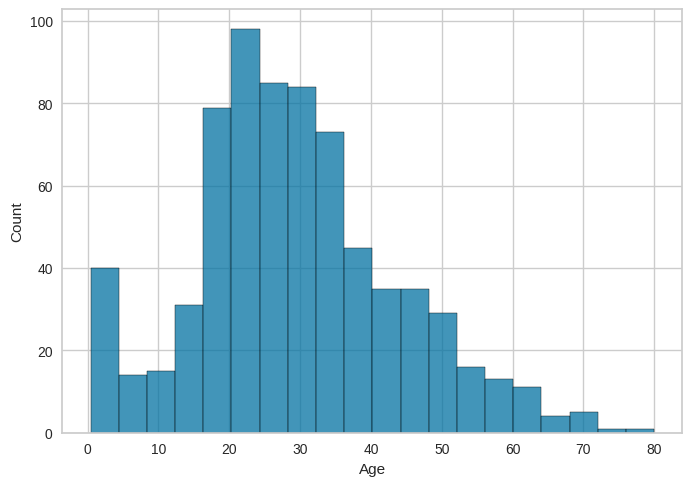

In [ ]:
srn.histplot(base.Age)


<Axes: xlabel='Age'>

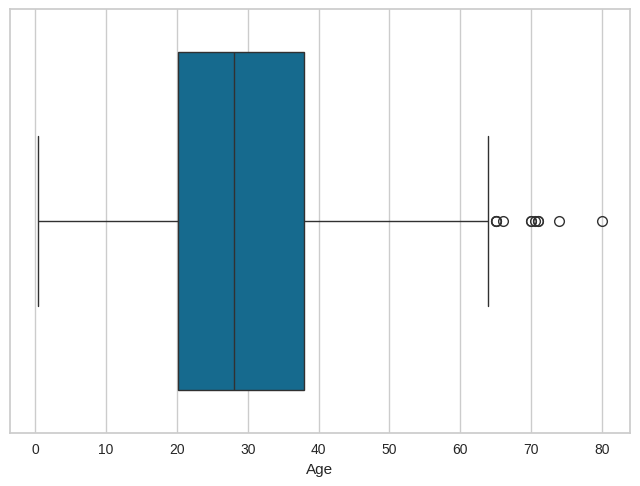

In [ ]:
srn.boxplot(data=base.Age, orient='h')

######A variável "Age" parece estar dispersa de uma maneira coerente, com sua mediana e média muito próximas (~ 28 e 29 anos). Para substituir os valores NAN deste atributo, vamos usar sua mediana, porém só quando formos dividir a base entre treinamento e teste.

<Axes: xlabel='Fare', ylabel='Count'>

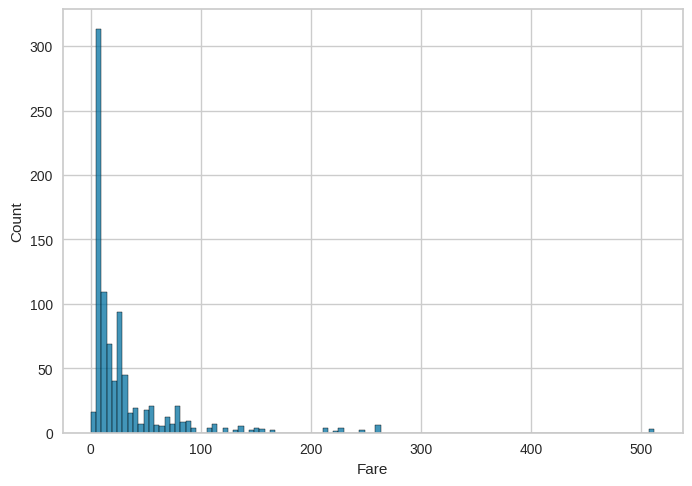

In [ ]:
srn.histplot(base.Fare)

<Axes: xlabel='Fare'>

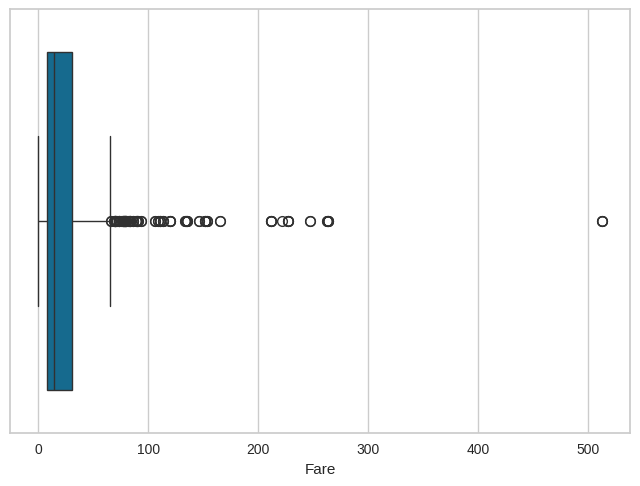

In [ ]:
srn.boxplot(data=base.Fare, orient='h')

######Valores para os ticktes encontram-se em sua grande maioria em valores baixos, com muitos outliers. Para substituir os valores NAN deste atributo, vamos usar sua mediana, porém só quando formos dividir a base entre treinamento e teste.

#Criando os atributos

######Vamos descartas columas de texto que neste caso não agregam nada para o modelo e a coluna de indexação desnecessária também.

In [ ]:
base.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

######Descarte das colunas "PassengerId", "Name", "Ticket" e "Cabin"

#####Criação das colunas dummy para os atributos Sex e Embarked

In [ ]:
base = base.drop(columns=["PassengerId","Name","Ticket","Cabin"])

In [ ]:
base

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [ ]:
base = pd.get_dummies(base, drop_first=True)

In [ ]:
base

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True
...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,True,False,True
887,1,1,19.0,0,0,30.0000,False,False,True
888,0,3,NaN,1,2,23.4500,False,False,True
889,1,1,26.0,0,0,30.0000,True,False,False


######Como para esse modelo de classificação estamos buscando uma predição no formato y = f(X), vamos separar a resposta (y) do dataframe dos atributos preditivos (X)

In [ ]:
y = base.Survived
y

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


In [ ]:
X = base.drop(columns=["Survived"])
X

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True
3,1,35.0,1,0,53.1000,False,False,True
4,3,35.0,0,0,8.0500,True,False,True
...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,True,False,True
887,1,19.0,0,0,30.0000,False,False,True
888,3,NaN,1,2,23.4500,False,False,True
889,1,26.0,0,0,30.0000,True,False,False


#Separação das amostras de treinamento e teste

######Vamos utilizar o scikit-learn para separar as amostras entre teste e treinamento. 70% dos dados para treinamento e 30% para teste.
######Utilizaremos estratificação na classe alvo (y) para manter a proporção entre os dados de treino e teste.

In [ ]:
#Avaliando a proporção da classe alvo (0 e 1)
print("Proporção original:")
print(y.value_counts(normalize=True))

Proporção original:
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [ ]:
#Vamos gerar uma amostra de treino e teste sem estratificar o alvo para avaliarmos
X_train_sem, X_test_sem, y_train_sem, y_test_sem = train_test_split(X, y, test_size=0.3, random_state=42)
print("\nSem estratificação")
print("Treino:", y_train_sem.value_counts(normalize=True))
print("Teste:", y_test_sem.value_counts(normalize=True))


Sem estratificação
Treino: Survived
0    0.629213
1    0.370787
Name: proportion, dtype: float64
Teste: Survived
0    0.585821
1    0.414179
Name: proportion, dtype: float64


In [ ]:
#Amostra de treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("\nCom estratificação")
print("Treino", y_train.value_counts(normalize=True))
print("Test", y_test.value_counts(normalize=True))


Com estratificação
Treino Survived
0    0.616372
1    0.383628
Name: proportion, dtype: float64
Test Survived
0    0.615672
1    0.384328
Name: proportion, dtype: float64


######Temos amostra de treino e teste em proporções iguais, o que favorece o treinamento e teste do modelo.

#Imputação de dados

######Como visto abaixo, o atributo "Age" ainda possui dados nulos. Devemos atribuir valores para essas entradas. Para isso usaremos a mediana da base de treinamento para substituir tanto os valores faltantes em treinamento como em teste. Usaremos os valores de treinamento para substituir os valores de teste para não causarmos vazamento de dados no modelo.

In [ ]:
X_train.isnull().sum()

,0
Pclass,0
Age,119
SibSp,0
Parch,0
Fare,0
Sex_male,0
Embarked_Q,0
Embarked_S,0


In [ ]:
X_test.isnull().sum()

,0
Pclass,0
Age,58
SibSp,0
Parch,0
Fare,0
Sex_male,0
Embarked_Q,0
Embarked_S,0


In [ ]:
mediana_treinamento = X_train.median()
mediana_treinamento

,0
Pclass,3.0
Age,29.0
SibSp,0.0
Parch,0.0
Fare,13.5
Sex_male,1.0
Embarked_Q,0.0
Embarked_S,1.0


In [ ]:
X_train = X_train.fillna(mediana_treinamento)
X_test = X_test.fillna(mediana_treinamento)

In [ ]:
X_train.isnull().sum()

,0
Pclass,0
Age,0
SibSp,0
Parch,0
Fare,0
Sex_male,0
Embarked_Q,0
Embarked_S,0


In [ ]:
X_test.isnull().sum()

,0
Pclass,0
Age,0
SibSp,0
Parch,0
Fare,0
Sex_male,0
Embarked_Q,0
Embarked_S,0


In [ ]:
X_train.shape

(623, 8)

In [ ]:
X_test.shape

(268, 8)

In [ ]:
X_train

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
748,1,19.0,1,0,53.1000,True,False,True
45,3,29.0,0,0,8.0500,True,False,True
28,3,29.0,0,0,7.8792,False,True,False
633,1,29.0,0,0,0.0000,True,False,True
403,3,28.0,1,0,15.8500,True,False,True
...,...,...,...,...,...,...,...,...
476,2,34.0,1,0,21.0000,True,False,True
190,2,32.0,0,0,13.0000,False,False,True
736,3,48.0,1,3,34.3750,False,False,True
462,1,47.0,0,0,38.5000,True,False,True


#Normalização dos dados

######Normalizar os dados vai nos ajudar a ter um melhor desempenho em alguns modelos, principalmente para aqueles que dependem de uma métrica de distância para calcular semelhança. Com isso nossos modelos não vão dar maior relevância para variáveis distintas.

In [ ]:
colunas_normalizar = "Pclass,Age,SibSp,Parch,Fare".split(",")
print(colunas_normalizar)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [ ]:
#Criando normalizador
sca = preprocessing.StandardScaler()

In [ ]:
X_train[colunas_normalizar] = sca.fit_transform(X_train[colunas_normalizar])
X_test[colunas_normalizar] = sca.transform(X_test[colunas_normalizar])

In [ ]:
X_train

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
748,-1.589202,-0.831890,0.562957,-0.448665,0.465738,True,False,True
45,0.819734,-0.064873,-0.474682,-0.448665,-0.478269,True,False,True
28,0.819734,-0.064873,-0.474682,-0.448665,-0.481848,False,True,False
633,-1.589202,-0.064873,-0.474682,-0.448665,-0.646954,True,False,True
403,0.819734,-0.141574,0.562957,-0.448665,-0.314823,True,False,True
...,...,...,...,...,...,...,...,...
476,-0.384734,0.318636,0.562957,-0.448665,-0.206906,True,False,True
190,-0.384734,0.165232,-0.474682,-0.448665,-0.374544,False,False,True
736,0.819734,1.392460,0.562957,3.119650,0.073362,False,False,True
462,-1.589202,1.315758,-0.474682,-0.448665,0.159800,True,False,True


# Criação de Modelo Base

Vamos criar um modelo simples para termos uma  base de comparação para nosso modelo. O método DummyClassifier do sklearn pode nos ajudar com essa tarefa.

In [ ]:
#Importação do método
from sklearn.dummy import DummyClassifier

In [ ]:
#Treino e cálculo da acurácia do modelo simplificado
dm = DummyClassifier()
dm.fit(X_train, y_train)
dm.score(X_test, y_test)

0.6156716417910447

In [ ]:
#Cálculo da precisão do modelo simplificado
from sklearn import metrics
y_predict = dm.predict(X_test)
# y_predict
metrics.precision_score(y_test, y_predict)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

In [ ]:
print(confusion_matrix(y_test, y_predict))


[[165   0]
 [103   0]]


#Falar sobre família de algoritmos

In [ ]:
#Concatenar base e algo de teste e treino novamente para utilizar na validação cruzada.
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [ ]:
#Importar família de algoritmos que serão testados
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import (LogisticRegression)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import (KNeighborsClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier)
import xgboost


In [ ]:
for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier,
]:
  cls = model()
  kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
  s = model_selection.cross_val_score(cls, X, y, scoring="roc_auc", cv=kfold)
  print(f"{model.__name__:25} AUC: {s.mean():.3f} STD: {s.std():.2f}")


DummyClassifier           AUC: 0.500 STD: 0.00
LogisticRegression        AUC: 0.859 STD: 0.04
DecisionTreeClassifier    AUC: 0.765 STD: 0.07
KNeighborsClassifier      AUC: 0.833 STD: 0.05
GaussianNB                AUC: 0.831 STD: 0.05
SVC                       AUC: 0.846 STD: 0.04
RandomForestClassifier    AUC: 0.865 STD: 0.04
XGBClassifier             AUC: 0.873 STD: 0.04


#Criação do modelo

De acordo com o desempenho dos modelos acima, decidi usar um classificador XGBOOST. Vamos analisar seu desempenho na base de teste, mas também na base de treinamento para ver seu comportamento em ambos.

In [ ]:
#Importação do classificador e das métricas de análise utilizadas
import xgboost
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Criando o modelo

xgb_model = xgboost.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, eval_metric='logloss')
print(xgb_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)


In [ ]:
#Treinar o modelo

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
#Fazer predições no teste e treino

#Predições na treino
y_pred_train = xgb_model.predict(X_train)
y_proba_train = xgb_model.predict_proba(X_train)[:, 1]
# print(y_pred_train)
# print(y_proba_train)

#Predições no teste
y_pred_test = xgb_model.predict(X_test)
y_proba_test = xgb_model.predict_proba(X_test)[:, 1]



In [ ]:
#Avaliar na base de treino

train_accuracy = xgb_model.score(X_train, y_train)
train_auc = roc_auc_score(y_train, y_proba_train)

print(f"\nAcurácia (Treino): {train_accuracy}")
print(f"\nAUC (Treino): {train_auc}")
print("\nRelatório de Classificação (Treino):")
print(classification_report(y_train, y_pred_train))


Acurácia (Treino): 0.9245585874799358

AUC (Treino): 0.9755981956066947

Relatório de Classificação (Treino):
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       384
           1       0.94      0.86      0.90       239

    accuracy                           0.92       623
   macro avg       0.93      0.91      0.92       623
weighted avg       0.93      0.92      0.92       623



In [ ]:
#Avaliar na base de teste

test_accuracy = xgb_model.score(X_test, y_test)
test_auc = roc_auc_score(y_test, y_proba_test)

print(f"\nAcurácia (Teste):{test_accuracy}")
print(f"\nAUC (Teste):{test_auc}")
print("\nRelatório de Classificação (Teste):")
print(classification_report(y_test, y_pred_test))


Acurácia (Teste):0.7947761194029851

AUC (Teste):0.8373345101500442

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       165
           1       0.77      0.66      0.71       103

    accuracy                           0.79       268
   macro avg       0.79      0.77      0.78       268
weighted avg       0.79      0.79      0.79       268



In [ ]:
#Matriz de confusão
cm = confusion_matrix(y_test, y_pred_test)
print(cm)


[[145  20]
 [ 35  68]]


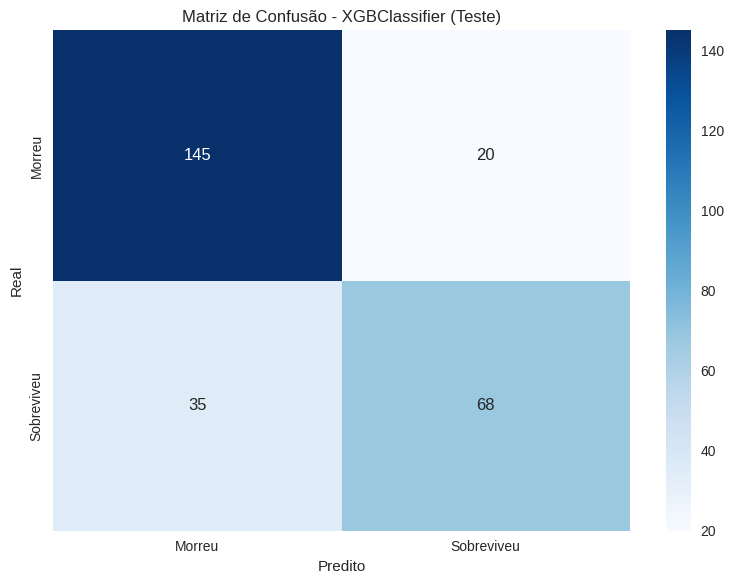

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Morreu', 'Sobreviveu'],
            yticklabels=['Morreu', 'Sobreviveu'])
plt.title('Matriz de Confusão - XGBClassifier (Teste)')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.tight_layout()
plt.show()

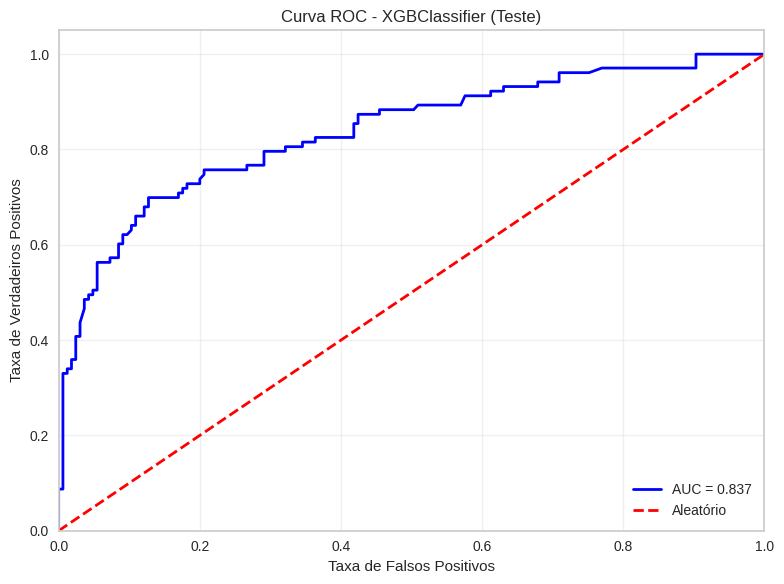

In [ ]:
#Curva ROC

fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {test_auc:.3f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - XGBClassifier (Teste)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Ordenar por importância
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importância': feature_importance
})

print("\nImportância das Features:")
print(importance_df)


Importância das Features:
      Feature  Importância
0      Pclass     0.171279
1         Age     0.045202
2       SibSp     0.041823
3       Parch     0.024130
4        Fare     0.041224
5    Sex_male     0.609771
6  Embarked_Q     0.030313
7  Embarked_S     0.036257
